In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
from torchsummary import summary
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
import time
from torchsummary import summary
import numpy as np
%matplotlib inline

In [2]:
# mean = 0.5
# std = 0.5
mean = 0.1307
std = 0.3081
transformtion = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),  # 数据增广
#     transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((mean,),(std,))]
)

In [3]:
train_dataset = datasets.MNIST('./mnist',train=True,transform = transformtion, download=True)
test_dataset = datasets.MNIST('./mnist',train=False,transform = transformtion, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=True, num_workers=4)

In [4]:
len(train_dataset),len(test_dataset)

(60000, 10000)

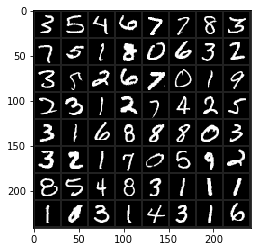

In [5]:
import matplotlib.pyplot as plt
def plot_img(image):
    image = image.numpy()[0]
    # print(image.shape)
    image = ((mean * image) + std)
    plt.imshow(image ,cmap='gray')

images, label =  next(iter(train_loader))
img = torchvision.utils.make_grid(images)
img= img.numpy().transpose(1,2,0)
img = img*std + mean
plt.imshow(img)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda


![在这里插入图片描述](https://img-blog.csdnimg.cn/20210701181621478.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80NTUwODI2NQ==,size_16,color_FFFFFF,t_70)

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # 输入 1 * 28 * 28
        self.conv = nn.Sequential(
            # 卷积层1
            # 在输入基础上增加了padding，28 * 28 -> 32 * 32
            # 1 * 32 * 32 -> 6 * 28 * 28
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), nn.ReLU(),
            # 6 * 28 * 28 -> 6 * 14 * 14
            nn.MaxPool2d(kernel_size=2, stride=2), # kernel_size, stride
            # 卷积层2
            # 6 * 14 * 14 -> 16 * 10 * 10 
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), nn.ReLU(),
            # 16 * 10 * 10 -> 16 * 5 * 5
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc = nn.Sequential(
            # 全连接层1
            nn.Linear(in_features=16 * 5 * 5, out_features=120), 
            nn.ReLU(),
            # 全连接层2
            nn.Linear(in_features=120, out_features=84), 
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        )
    def forward(self, img):
        img = self.conv(img)
        out = img.view(img.size(0),-1)
        out = self.fc(out)
        return out

In [8]:
net = LeNet().to(device)
print(net)

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [9]:
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [10]:
x = torch.randn(2,1,28,28).to(device)
print(x.shape)
y = net(x)
print(y.shape)

torch.Size([2, 1, 28, 28])
torch.Size([2, 10])


In [11]:
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4
nepochs = 300

In [12]:
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True) # 优化器
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 0.000001) # 动态更新学习率

In [13]:
im,label = next(iter(train_loader))
print(im.shape,label.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [14]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

for epoch in range(nepochs):
    train_loss = 0
    train_acc = 0
    net.train()
    since = time.time()
    for im, label in train_loader:
        im = im.to(device)
        label = label.to(device)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        train_acc += acc
    
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    net.eval() # 将模型改为预测模式
    for im, label in test_loader:
        im = im.to(device)
        label = label.to(device)
        out = net(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
    scheduler.step(train_loss)
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    now = time.time()
    print('[%3d/%d, %.0f seconds]|\t loss: %5.5f, accuaracy: %2.2f%%\t|\tval_loss: %5.5f, val_accuaracy: %2.2f%%'%
          (epoch+1, nepochs, now-since, 
           100*train_loss / len(train_loader), 100*train_acc / len(train_loader),
           100*eval_loss / len(test_loader), 100*eval_acc / len(test_loader)))

[  1/300, 10 seconds]|	 loss: 104.66350, accuaracy: 67.11%	|	val_loss: 24.29202, val_accuaracy: 92.71%
[  2/300, 10 seconds]|	 loss: 19.22227, accuaracy: 94.34%	|	val_loss: 13.35584, val_accuaracy: 95.85%
[  3/300, 10 seconds]|	 loss: 12.79474, accuaracy: 96.21%	|	val_loss: 9.62949, val_accuaracy: 96.97%
[  4/300, 10 seconds]|	 loss: 10.23424, accuaracy: 96.94%	|	val_loss: 8.46691, val_accuaracy: 97.22%
[  5/300, 9 seconds]|	 loss: 8.78554, accuaracy: 97.30%	|	val_loss: 7.14007, val_accuaracy: 97.64%
[  6/300, 9 seconds]|	 loss: 7.66269, accuaracy: 97.72%	|	val_loss: 6.41874, val_accuaracy: 97.90%
[  7/300, 9 seconds]|	 loss: 6.84873, accuaracy: 97.90%	|	val_loss: 6.41705, val_accuaracy: 97.87%
[  8/300, 9 seconds]|	 loss: 6.18006, accuaracy: 98.09%	|	val_loss: 5.65497, val_accuaracy: 98.05%
[  9/300, 9 seconds]|	 loss: 5.72081, accuaracy: 98.29%	|	val_loss: 5.22951, val_accuaracy: 98.35%
[ 10/300, 10 seconds]|	 loss: 5.19603, accuaracy: 98.36%	|	val_loss: 5.28417, val_accuaracy: 98.12

[ 84/300, 9 seconds]|	 loss: 0.33071, accuaracy: 99.95%	|	val_loss: 3.59707, val_accuaracy: 99.03%
[ 85/300, 9 seconds]|	 loss: 0.32421, accuaracy: 99.95%	|	val_loss: 3.75173, val_accuaracy: 98.94%
[ 86/300, 9 seconds]|	 loss: 0.33153, accuaracy: 99.95%	|	val_loss: 3.58400, val_accuaracy: 99.06%
[ 87/300, 9 seconds]|	 loss: 0.31262, accuaracy: 99.95%	|	val_loss: 3.58632, val_accuaracy: 98.93%
[ 88/300, 10 seconds]|	 loss: 0.29825, accuaracy: 99.96%	|	val_loss: 3.54969, val_accuaracy: 99.04%
[ 89/300, 10 seconds]|	 loss: 0.28199, accuaracy: 99.97%	|	val_loss: 3.51622, val_accuaracy: 99.07%
[ 90/300, 9 seconds]|	 loss: 0.28975, accuaracy: 99.97%	|	val_loss: 3.83645, val_accuaracy: 98.92%
[ 91/300, 9 seconds]|	 loss: 0.29947, accuaracy: 99.95%	|	val_loss: 3.94092, val_accuaracy: 98.96%
[ 92/300, 10 seconds]|	 loss: 0.31142, accuaracy: 99.95%	|	val_loss: 3.59114, val_accuaracy: 99.07%
[ 93/300, 9 seconds]|	 loss: 0.27606, accuaracy: 99.97%	|	val_loss: 3.52470, val_accuaracy: 99.04%
[ 94/30

[165/300, 9 seconds]|	 loss: 0.16640, accuaracy: 100.00%	|	val_loss: 3.44832, val_accuaracy: 99.07%
[166/300, 9 seconds]|	 loss: 0.16630, accuaracy: 100.00%	|	val_loss: 3.42980, val_accuaracy: 99.06%
Epoch   167: reducing learning rate of group 0 to 6.2500e-05.
[167/300, 9 seconds]|	 loss: 0.16560, accuaracy: 100.00%	|	val_loss: 3.47732, val_accuaracy: 99.02%
[168/300, 9 seconds]|	 loss: 0.16430, accuaracy: 100.00%	|	val_loss: 3.43936, val_accuaracy: 99.06%
[169/300, 9 seconds]|	 loss: 0.16388, accuaracy: 100.00%	|	val_loss: 3.42657, val_accuaracy: 99.06%
[170/300, 9 seconds]|	 loss: 0.16387, accuaracy: 100.00%	|	val_loss: 3.42791, val_accuaracy: 99.06%
[171/300, 9 seconds]|	 loss: 0.16368, accuaracy: 100.00%	|	val_loss: 3.43186, val_accuaracy: 99.06%
[172/300, 9 seconds]|	 loss: 0.16405, accuaracy: 100.00%	|	val_loss: 3.55521, val_accuaracy: 99.00%
[173/300, 9 seconds]|	 loss: 0.16397, accuaracy: 100.00%	|	val_loss: 3.42024, val_accuaracy: 99.06%
[174/300, 9 seconds]|	 loss: 0.16426, 

[243/300, 12 seconds]|	 loss: 0.16168, accuaracy: 100.00%	|	val_loss: 3.42547, val_accuaracy: 99.06%
[244/300, 12 seconds]|	 loss: 0.16167, accuaracy: 100.00%	|	val_loss: 3.42957, val_accuaracy: 99.06%
[245/300, 12 seconds]|	 loss: 0.16165, accuaracy: 100.00%	|	val_loss: 3.41842, val_accuaracy: 99.06%
[246/300, 13 seconds]|	 loss: 0.16168, accuaracy: 100.00%	|	val_loss: 3.41847, val_accuaracy: 99.06%
[247/300, 12 seconds]|	 loss: 0.16165, accuaracy: 100.00%	|	val_loss: 3.41955, val_accuaracy: 99.06%
[248/300, 12 seconds]|	 loss: 0.16200, accuaracy: 100.00%	|	val_loss: 3.41838, val_accuaracy: 99.06%
[249/300, 13 seconds]|	 loss: 0.16173, accuaracy: 100.00%	|	val_loss: 3.41874, val_accuaracy: 99.06%
[250/300, 13 seconds]|	 loss: 0.16172, accuaracy: 100.00%	|	val_loss: 3.41965, val_accuaracy: 99.06%
[251/300, 11 seconds]|	 loss: 0.16192, accuaracy: 100.00%	|	val_loss: 3.41892, val_accuaracy: 99.06%
[252/300, 15 seconds]|	 loss: 0.16195, accuaracy: 100.00%	|	val_loss: 3.41840, val_accuarac

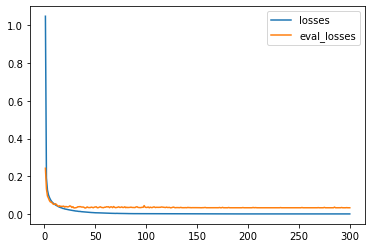

In [15]:
plt.plot(range(1,nepochs+1),losses,label='losses')
plt.plot(range(1,nepochs+1),eval_losses,label='eval_losses')
plt.legend(loc='best')

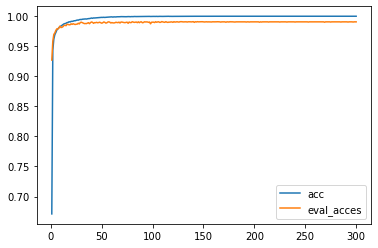

In [17]:
plt.plot(range(1,nepochs+1),acces,label='acc')
plt.plot(range(1,nepochs+1),eval_acces,label='eval_acces')
plt.legend(loc='best')

# 2.保存模型

In [18]:
PATH = './mnist_net2.pth'
torch.save(net, PATH)
torch.save(net, PATH)

In [19]:
net

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

# 3.读取并加载保存的模型

In [20]:
net2 = LeNet()
net2 = torch.load(PATH)

In [21]:
net2

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

Accuracy Rate = 100.0%


<Figure size 1800x288 with 0 Axes>

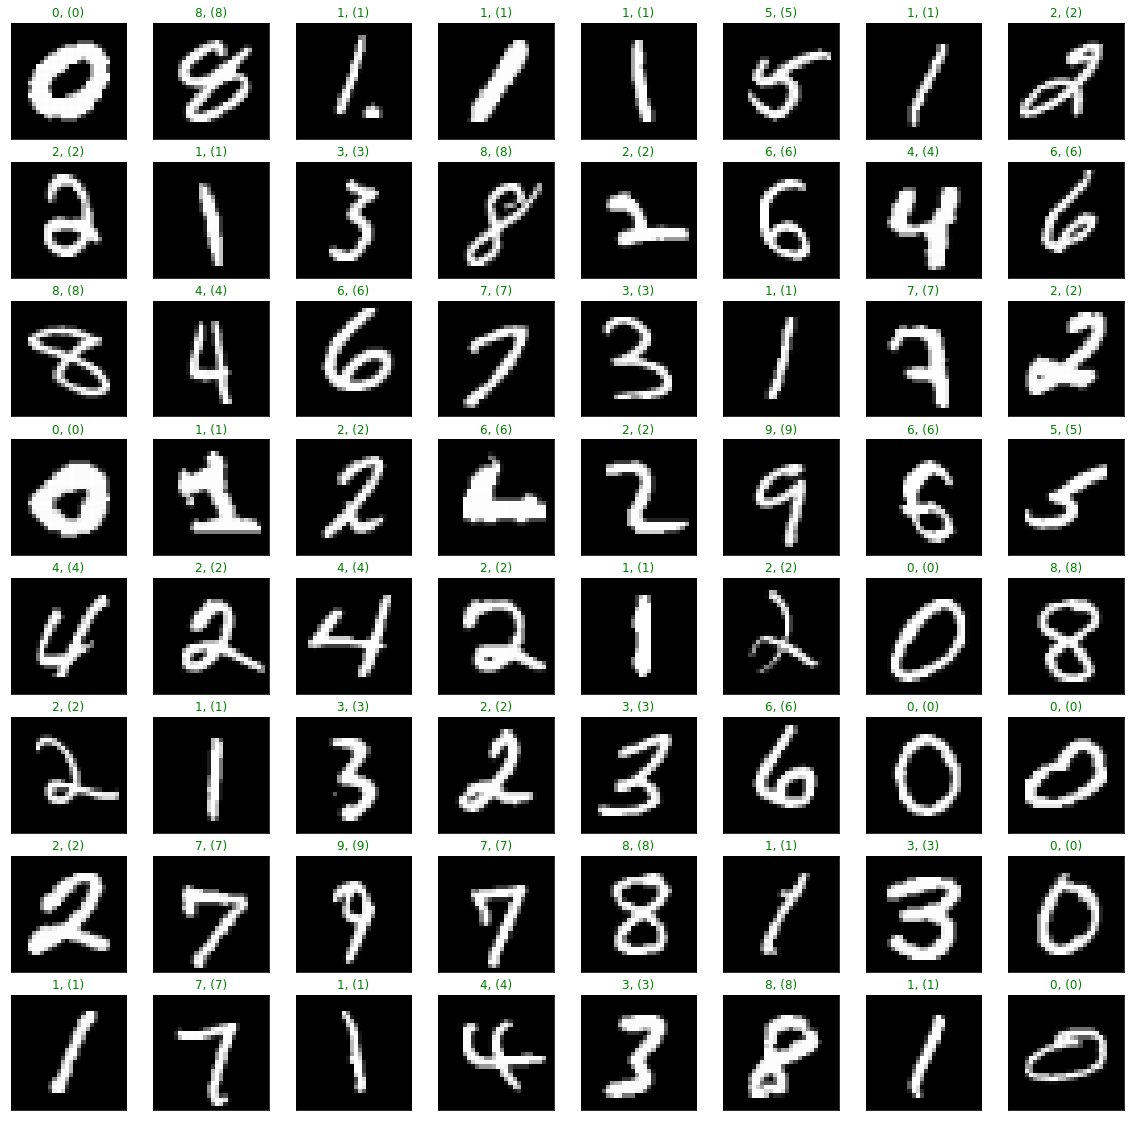

In [22]:
classes = ('0','1','2','3','4','5','6','7','8','9')
dataiter = iter(train_loader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(20,20))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    plot_img(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

In [23]:
#整个测试集上预测
correct = 0
total = 0
 
with torch.no_grad():
    for (images,labels) in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs,1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum()
 
print('10000张测试集合中的准确率为：', (correct.cpu().numpy()/total * 100))
print(correct)

10000张测试集合中的准确率为： 99.06
tensor(9906, device='cuda:0')


GroundTruth:      8     6     6     0
Predicted:      8     6     6     0
Accuracy of the network on the 10000 test images: 99.06 %
Accuracy of     0 : 99.69 %
Accuracy of     1 : 99.74 %
Accuracy of     2 : 99.32 %
Accuracy of     3 : 98.71 %
Accuracy of     4 : 99.08 %
Accuracy of     5 : 99.10 %
Accuracy of     6 : 98.75 %
Accuracy of     7 : 99.32 %
Accuracy of     8 : 98.67 %
Accuracy of     9 : 98.12 %


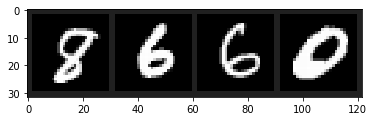

In [24]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]
# print images
plot_img(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = net(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % 
      (100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))